# 1. Getting VizDoom Up and Running

In [1]:
# !pip install vizdoom

In [2]:
# !cd github & git clone https://github.com/mwydmuch/ViZDoom

In [3]:
# Import vizdoom for game env
from vizdoom import * 
# Import random for action sampling
import random
# Import time for sleeping
import time 
# Import numpy for identity matrix
import numpy as np

In [4]:
# import os
# os.getcwd()

In [5]:
# os.chdir('./github')
# os.getcwd()

In [6]:
# os.chdir('..')
# os.getcwd()

In [7]:
# Setup game
game = DoomGame()
game.load_config('github/VizDoom/scenarios/predict_position.cfg')
game.init()

In [8]:
# This is the set of actions we can take in the environment
actions = np.identity(3, dtype=np.uint8)

In [9]:
state = game.get_state()

In [10]:
state.game_variables

array([0.])

In [11]:
game.get_state().game_variables[0]

0.0

In [12]:
# Loop through episodes 
episodes = 10 
for episode in range(episodes): 
    # Create a new episode or game 
    game.new_episode()
    # Check the game isn't done 
    while not game.is_episode_finished(): 
        # Get the game state 
        state = game.get_state()
        # Get the game image 
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        # Take an action
        reward = game.make_action(random.choice(actions),4)
        # Print rewward 
        # print('reward:', reward) 
        time.sleep(0.02)
    print('Result:', game.get_total_reward())
    time.sleep(2)

Result: -0.005900000000000002
Result: -0.006700000000000002
Result: 0.9943000000000001
Result: -0.007900000000000003
Result: -0.008300000000000002
Result: -0.006300000000000002
Result: -0.007900000000000003
Result: -0.005900000000000002
Result: 0.9953000000000001
Result: -0.006700000000000002


In [13]:
game.close()

# 2. Converting it to a Gym Environment

In [14]:
#!pip install gym

In [15]:
# Import environment base class from OpenAI Gym
from gym import Env
# Import gym spaces 
from gym.spaces import Discrete, Box
# Import opencv 
import cv2

In [16]:
# Create Vizdoom OpenAI Gym Environment
class VizDoomGym(Env): 
    # Function that is called when we start the env
    def __init__(self, render=False, config='github/VizDoom/scenarios/predict_position.cfg'): 
        # Inherit from Env
        super().__init__()
        # Setup the game 
        self.game = DoomGame()
        self.game.load_config(config)
        
        # Render frame logic
        if render == False: 
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        
        # Start the game 
        self.game.init()
        
        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100,160,1), dtype=np.uint8) 
        self.action_space = Discrete(3)
        
        
    # This is how we take a step in the environment
    def step(self, action):
        # Specify action and take step 
        actions = np.identity(3)
        reward = self.game.make_action(actions[action], 4) 
        
        # Get all the other stuff we need to retun 
        if self.game.get_state(): 
            state = self.game.get_state().screen_buffer
            state = self.grayscale(state)
            
            
            killcount = self.game.get_state().game_variables[0] 
            info = killcount
        else: 
            state = np.zeros(self.observation_space.shape)
            info = 0 
        
        info = {"info":info}
        done = self.game.is_episode_finished()
        
        return state, reward, done, info 
    
    # Define how to render the game or environment 
    def render(): 
        pass
    
    # What happens when we start a new game 
    def reset(self): 
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state)
    
    # Grayscale the game frame and resize it 
    def grayscale(self, observation):
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160,100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100,160,1))
        return state
    
    # Call to close down the game
    def close(self): 
        self.game.close()

In [17]:
env = VizDoomGym(render=True)

In [18]:
res = env.step(2)
res[1]

-0.0004

In [19]:
res[1]

-0.0004

In [20]:
state = env.reset()

# 3. View Game State

In [21]:
env.reset()

array([[[ 39],
        [ 47],
        [ 47],
        ...,
        [ 47],
        [ 47],
        [ 46]],

       [[ 34],
        [ 45],
        [ 47],
        ...,
        [ 38],
        [ 47],
        [ 48]],

       [[ 40],
        [ 35],
        [ 35],
        ...,
        [ 47],
        [ 47],
        [ 48]],

       ...,

       [[ 92],
        [ 69],
        [ 67],
        ...,
        [ 56],
        [ 38],
        [ 33]],

       [[ 43],
        [ 72],
        [114],
        ...,
        [ 74],
        [101],
        [ 72]],

       [[ 73],
        [ 80],
        [ 59],
        ...,
        [108],
        [110],
        [ 92]]], dtype=uint8)

In [22]:
# Import Environment checker
from stable_baselines3.common import env_checker

In [23]:
env_checker.check_env(env)

# 3. View State

In [24]:
#!pip install matplotlib

In [25]:
from matplotlib import pyplot as plt

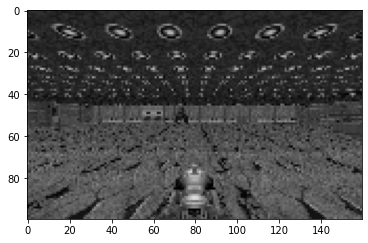

In [26]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

In [27]:
env.close()

# 4. Setup Callback

In [1]:
#!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device



In [29]:
#!pip install stable-baselines3[extra]

In [31]:
# Import os for file nav
import os 
# Import callback class from sb3
from stable_baselines3.common.callbacks import BaseCallback

In [32]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_pred_pos{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [33]:
CHECKPOINT_DIR = './train/train_corridor'
LOG_DIR = './logs/log_corridor'

In [34]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

# 5. Train Our Model Using Curriculum 

In [37]:
# import ppo for training
from stable_baselines3 import PPO

In [38]:
# Non rendered environment
env = VizDoomGym(config='github/VizDoom/scenarios/predict_position.cfg')

In [39]:
#model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.0001, n_steps=4096)
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=2048)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [40]:
model.load('./train/train_corridor/thirdcycle/best_model_pred_pos200000.zip')

In [41]:
#model.learn(total_timesteps=40000, callback=callback)
model.learn(total_timesteps=200000, callback=callback)

Logging to ./logs/log_corridor\PPO_5
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.1     |
|    ep_rew_mean     | 0.163    |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 70       |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 17.1         |
|    ep_rew_mean          | 0.0933       |
| time/                   |              |
|    fps                  | 21           |
|    iterations           | 2            |
|    time_elapsed         | 194          |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0003295783 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_varian

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.5        |
|    ep_rew_mean          | 0.263       |
| time/                   |             |
|    fps                  | 16          |
|    iterations           | 11          |
|    time_elapsed         | 1332        |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.001092598 |
|    clip_fraction        | 0.0112      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.812      |
|    explained_variance   | 0.0425      |
|    learning_rate        | 1e-05       |
|    loss                 | 0.0247      |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00104    |
|    value_loss           | 0.0479      |
-----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 16.1  

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 14.8         |
|    ep_rew_mean          | 0.294        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 21           |
|    time_elapsed         | 2578         |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0024477812 |
|    clip_fraction        | 0.0432       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.665       |
|    explained_variance   | 0.264        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.0353       |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00647     |
|    value_loss           | 0.0842       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 13.6         |
|    ep_rew_mean          | 0.475        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 31           |
|    time_elapsed         | 3836         |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0021465144 |
|    clip_fraction        | 0.0187       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.29        |
|    explained_variance   | 0.707        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.014        |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.00323     |
|    value_loss           | 0.053        |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 13.4         |
|    ep_rew_mean          | 0.535        |
| time/                   |              |
|    fps                  | 16           |
|    iterations           | 41           |
|    time_elapsed         | 5214         |
|    total_timesteps      | 83968        |
| train/                  |              |
|    approx_kl            | 0.0012796293 |
|    clip_fraction        | 0.0123       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.161       |
|    explained_variance   | 0.833        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.0141       |
|    n_updates            | 400          |
|    policy_gradient_loss | -0.000388    |
|    value_loss           | 0.0338       |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 13.3          |
|    ep_rew_mean          | 0.555         |
| time/                   |               |
|    fps                  | 16            |
|    iterations           | 51            |
|    time_elapsed         | 6516          |
|    total_timesteps      | 104448        |
| train/                  |               |
|    approx_kl            | 0.00022761055 |
|    clip_fraction        | 0.00684       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.049        |
|    explained_variance   | 0.857         |
|    learning_rate        | 1e-05         |
|    loss                 | 0.00124       |
|    n_updates            | 500           |
|    policy_gradient_loss | -0.000766     |
|    value_loss           | 0.0298        |
-------------------------------------------
-------------------------------------------
| rollout/                |     

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 13.4         |
|    ep_rew_mean          | 0.525        |
| time/                   |              |
|    fps                  | 15           |
|    iterations           | 61           |
|    time_elapsed         | 7811         |
|    total_timesteps      | 124928       |
| train/                  |              |
|    approx_kl            | 8.079037e-05 |
|    clip_fraction        | 0.00283      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0249      |
|    explained_variance   | 0.873        |
|    learning_rate        | 1e-05        |
|    loss                 | 0.0177       |
|    n_updates            | 600          |
|    policy_gradient_loss | -0.000748    |
|    value_loss           | 0.0295       |
------------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_m

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 13.2          |
|    ep_rew_mean          | 0.575         |
| time/                   |               |
|    fps                  | 15            |
|    iterations           | 71            |
|    time_elapsed         | 9290          |
|    total_timesteps      | 145408        |
| train/                  |               |
|    approx_kl            | 0.00026769738 |
|    clip_fraction        | 0.00317       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0488       |
|    explained_variance   | 0.895         |
|    learning_rate        | 1e-05         |
|    loss                 | 0.014         |
|    n_updates            | 700           |
|    policy_gradient_loss | -0.00132      |
|    value_loss           | 0.0235        |
-------------------------------------------
------------------------------------------
| rollout/                |      

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 13.3          |
|    ep_rew_mean          | 0.545         |
| time/                   |               |
|    fps                  | 15            |
|    iterations           | 81            |
|    time_elapsed         | 10700         |
|    total_timesteps      | 165888        |
| train/                  |               |
|    approx_kl            | 0.00033641083 |
|    clip_fraction        | 0.00439       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0331       |
|    explained_variance   | 0.922         |
|    learning_rate        | 1e-05         |
|    loss                 | 0.0116        |
|    n_updates            | 800           |
|    policy_gradient_loss | -0.000634     |
|    value_loss           | 0.0166        |
-------------------------------------------
-------------------------------------------
| rollout/                |     

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 13.6          |
|    ep_rew_mean          | 0.475         |
| time/                   |               |
|    fps                  | 15            |
|    iterations           | 90            |
|    time_elapsed         | 11936         |
|    total_timesteps      | 184320        |
| train/                  |               |
|    approx_kl            | 0.00048387525 |
|    clip_fraction        | 0.00522       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.0516       |
|    explained_variance   | 0.931         |
|    learning_rate        | 1e-05         |
|    loss                 | 0.00905       |
|    n_updates            | 890           |
|    policy_gradient_loss | -0.000612     |
|    value_loss           | 0.0122        |
-------------------------------------------
------------------------------------------
| rollout/                |      

# 6. Test the Model

In [42]:
# Import eval policy to test agent
from stable_baselines3.common.evaluation import evaluate_policy

In [43]:
# Reload model from disc
model = PPO.load('./train/train_corridor/best_model_pred_pos200000.zip')

In [44]:
# Create rendered environment
env = VizDoomGym(render=True, config='github/VizDoom/scenarios/predict_position.cfg')

In [45]:
# Evaluate mean reward for 10 games
mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=10)

C:\Users\Nicholas\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


In [46]:
for episode in range(20): 
    obs = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(action)
        time.sleep(0.02)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(total_reward, episode))
    time.sleep(2)

Total Reward for episode 0.9952000000000001 is 0
Total Reward for episode 0.9952000000000001 is 1
Total Reward for episode -0.005900000000000002 is 2
Total Reward for episode 0.9952000000000001 is 3
Total Reward for episode 0.9954000000000001 is 4
Total Reward for episode 0.9952000000000001 is 5
Total Reward for episode 0.9952000000000001 is 6
Total Reward for episode 0.9952000000000001 is 7
Total Reward for episode 0.9952000000000001 is 8
Total Reward for episode 0.9952000000000001 is 9
Total Reward for episode 0.9952000000000001 is 10
Total Reward for episode 0.9952000000000001 is 11
Total Reward for episode -0.005900000000000002 is 12
Total Reward for episode 0.9952000000000001 is 13
Total Reward for episode 0.9952000000000001 is 14
Total Reward for episode 0.9952000000000001 is 15
Total Reward for episode 0.9952000000000001 is 16
Total Reward for episode -0.005900000000000002 is 17
Total Reward for episode -0.005900000000000002 is 18
Total Reward for episode 0.9952000000000001 is 1